In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# !pip install emoji

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading dataset

In [2]:
train_data = pd.read_csv('./datasets/training-v1/offenseval-training-v1.tsv' , sep='\t')
train_data.drop(['id'], axis=1, inplace = True)

In [3]:
trial_data = pd.read_csv('./datasets/training-v1/offenseval-trial.tsv' , names=['tweet','subtask_a','subtask_b','subtask_c' ], sep='\t')

In [4]:
train_data = pd.concat([trial_data, train_data], ignore_index=True)

In [5]:
train_data.shape

(13560, 4)

## Exploratory Data Analysis

In [6]:
train_data.tail()

,tweet,subtask_a,subtask_b,subtask_c
13555,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13556,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13557,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13558,@USER Pussy,OFF,UNT,NaN
13559,#Spanishrevenge vs. #justice #HumanRights and ...,NOT,NaN,NaN


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13560 entries, 0 to 13559
Data columns (total 4 columns):
tweet        13560 non-null object
subtask_a    13560 non-null object
subtask_b    4477 non-null object
subtask_c    3915 non-null object
dtypes: object(4)
memory usage: 423.8+ KB


In [8]:
train_data = train_data[train_data.subtask_c != 'ORG']


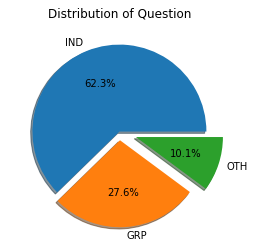

In [9]:
ax=train_data['subtask_c'].value_counts().plot.pie(explode=[0,0.1,0.2],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Individual:  2437
Group :  1078
Other :  397


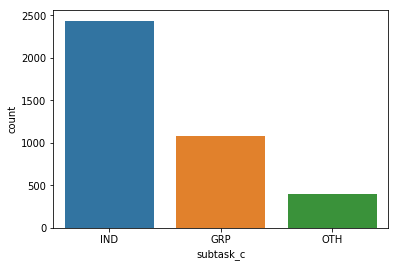

In [10]:
plot_sb = sb.countplot(train_data['subtask_c'], label='Total')
IND, GRP ,OTH  = train_data['subtask_c'].value_counts()
print('Individual: ',IND)
print('Group : ',GRP)
print('Other : ',OTH)

## Preprocessing Dataset

In [11]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text


In [12]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [13]:
train_data['subtask_c'].replace({'IND':0, 'GRP': 1, 'OTH': 2}, inplace= True)

In [14]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

In [15]:
train_data = train_data.dropna(subset=['subtask_c'])

In [16]:
train_data.head()

,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
26,@hughhewitt @mishacollins What the hell...? Wh...,OFF,TIN,0.0,hughhewitt mishacollins what the hell ? what d...
28,Guess ima have to beat some lil kids asses tod...,OFF,TTH,0.0,guess ima have to beat some lil kids asses tod...
64,@BreitbartNews Little Marco Trump will get thi...,OFF,TIN,0.0,breitbart news little marco trump will get thi...
72,@realDonaldTrump Everyone already know what yo...,OFF,TIN,0.0,real donald trump everyone already know what y...
78,if it's not about me its about Matt. blah blah...,OFF,TIN,0.0,if it ' s not about me its about matt blah wor...


In [17]:
train_data["preprocessed_tweet"].shape

(3912,)

## Feature Extraction

In [18]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_c"].values

In [19]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [20]:
print("Train shape : ",train_X.shape)
#print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (2934,)
Test shape :  (978,)


In [21]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

# unique, counts = np.unique(val_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 1.828e+03]
 [1.000e+00 8.080e+02]
 [2.000e+00 2.980e+02]]
[[  0. 609.]
 [  1. 270.]
 [  2.  99.]]


In [22]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_c'] = test_y
testdf.shape

(978, 2)

### Using TFIDF

In [23]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

### Using Count Vectorizer

In [24]:
def count_vectorizer(X, train_X, test_X):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(X)

    train_text_features_cv = count_vectorizer.transform(train_X)
    test_text_features_cv = count_vectorizer.transform(test_X)
    
    return train_text_features_cv, test_text_features_cv

## Undersampling

In [25]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    return X_resampled, y_resampled

## Oversampling

In [26]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

## Function for Confusion Matrix

In [27]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

## Model

In [28]:
def model(model, X, train_X, train_y, test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tfidf_vectorizer(X, train_X, test_X)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count_vectorizer(X, train_X, test_X)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_y = undersampleData(train_text_features, train_y)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_y = oversampleData(train_text_features, train_y)
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="weighted"))
    print('Recall', recall_score(predictions, test_y, average="weighted"))

    getConfusionMatrix(test_y, predictions)

## Naive Bayes (Unsampling, TFIDF)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  52.04498977505112
F1Score 0.4525302770008521
Precision 0.5262070369749658
Recall 0.5204498977505112
Sensitivity: 87.00%
Specificity: 60.61%


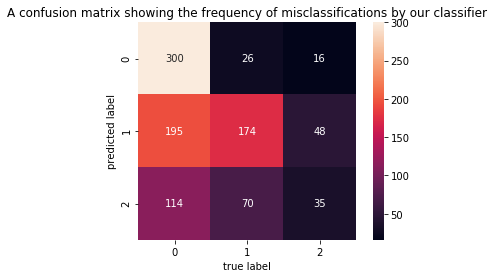

In [29]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

## Naive Bayes (Unsampling, CV)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  51.22699386503068
F1Score 0.4504031208479864
Precision 0.5187974367263557
Recall 0.5122699386503068
Sensitivity: 87.24%
Specificity: 61.09%


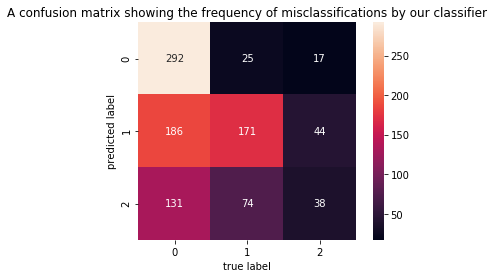

In [30]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

## Naive Bayes

Feature Extraction using CV
Accuracy Score ->  67.280163599182
F1Score 0.4419281162040623
Precision 0.7665834082342086
Recall 0.6728016359918201
Sensitivity: 46.47%
Specificity: 88.35%


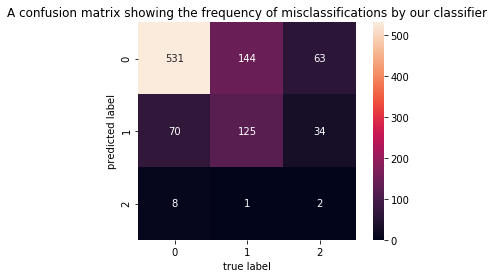

In [31]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  62.47443762781187
F1Score 0.26335317615848436
Precision 0.9943201444364973
Recall 0.6247443762781186
Sensitivity: 1.11%
Specificity: 99.84%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


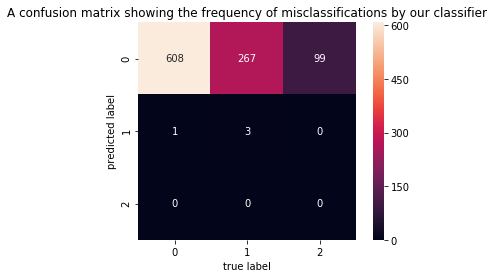

In [32]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

### Naive Bayes (Oversampling, CV)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  52.556237218813905
F1Score 0.32307005800981703
Precision 0.6696201337622958
Recall 0.5255623721881391
Sensitivity: 0.00%
Specificity: 100.00%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


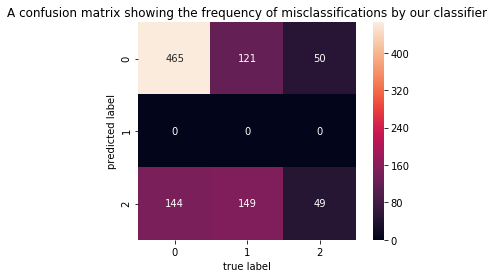

In [33]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

### Naive Bayes (Oversampling, TFIDF)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  53.06748466257669
F1Score 0.3255091552406633
Precision 0.6772235435235224
Recall 0.5306748466257669
Sensitivity: 0.00%
Specificity: 100.00%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


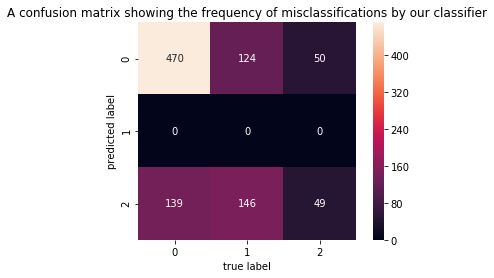

In [34]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

## SVM (Undersampling, TFIDF)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  57.46421267893661
F1Score 0.47756535376300446
Precision 0.5402612971261161
Recall 0.5746421267893661
Sensitivity: 70.35%
Specificity: 81.71%


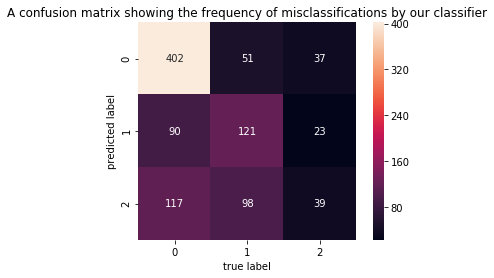

In [35]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

## SVM (Undersampling, CV)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  55.419222903885476
F1Score 0.46164228274668034
Precision 0.5310327936094807
Recall 0.5541922290388548
Sensitivity: 61.71%
Specificity: 79.80%


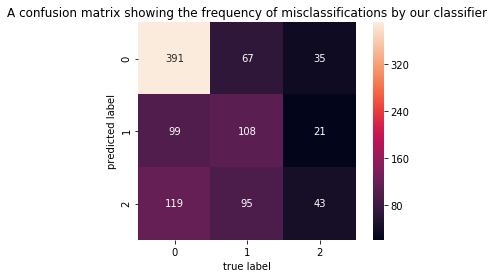

In [36]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

## SVM

Feature Extraction using CV
Accuracy Score ->  67.48466257668711
F1Score 0.49203902030481955
Precision 0.7146632187673018
Recall 0.6748466257668712
Sensitivity: 55.83%
Specificity: 87.12%


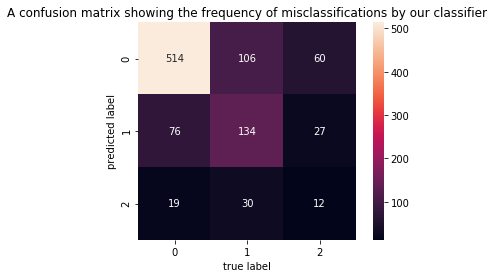

In [37]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  71.06339468302659
F1Score 0.4673946895152379
Precision 0.8170520521483077
Recall 0.7106339468302658
Sensitivity: 52.22%
Specificity: 90.95%


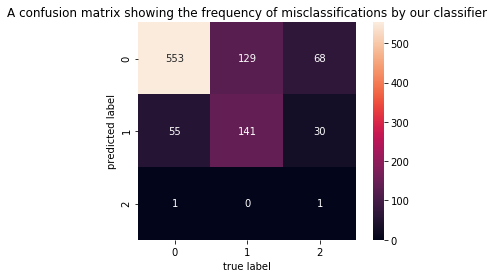

In [38]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  69.12065439672801
F1Score 0.5114609998341018
Precision 0.7431034516677278
Recall 0.6912065439672802
Sensitivity: 51.05%
Specificity: 92.28%


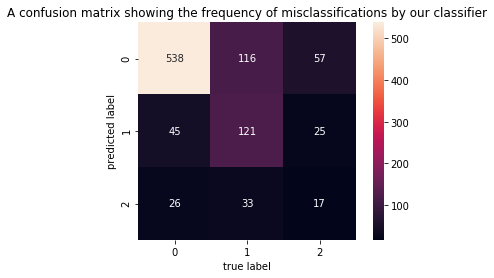

In [39]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)

Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  60.02044989775052
F1Score 0.4716290561568803
Precision 0.5841937903146562
Recall 0.6002044989775052
Sensitivity: 53.49%
Specificity: 87.11%


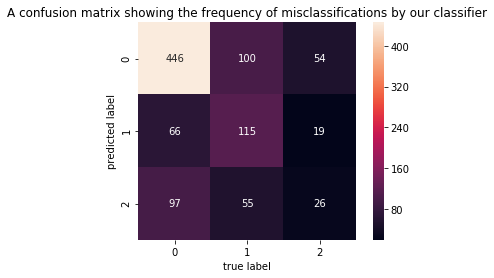

In [40]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)

### Random Forest

Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  51.84049079754601
F1Score 0.3150222575375013
Precision 0.654303916394037
Recall 0.5184049079754601
Sensitivity: 3.03%
Specificity: 99.79%


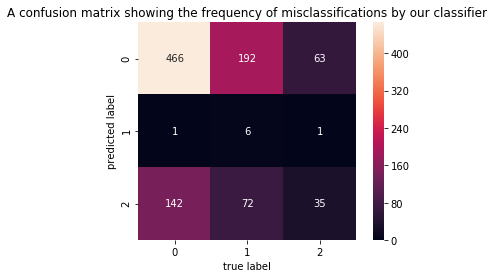

In [41]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)


Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  61.75869120654397
F1Score 0.5060000327925396
Precision 0.5948759949147793
Recall 0.6175869120654397
Sensitivity: 63.33%
Specificity: 81.95%


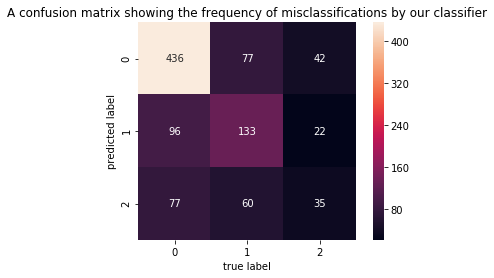

In [42]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)


Feature Extraction using CV
Accuracy Score ->  63.59918200408998
F1Score 0.2926803074170845
Precision 0.9784316260411036
Recall 0.6359918200408998
Sensitivity: 5.56%
Specificity: 99.67%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


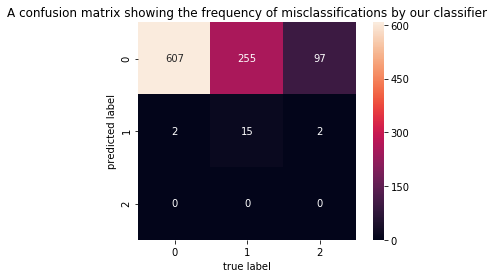

In [43]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Accuracy Score ->  63.70143149284253
F1Score 0.29498711249205567
Precision 0.9785035793850405
Recall 0.6370143149284253
Sensitivity: 5.93%
Specificity: 99.67%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


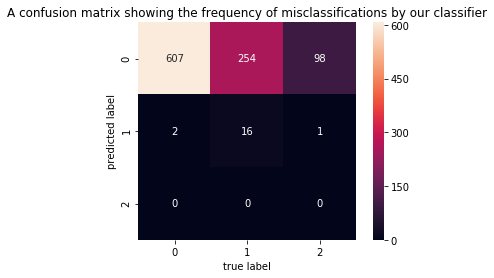

In [44]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  58.99795501022494
F1Score 0.48557307246611153
Precision 0.5570905443975044
Recall 0.5899795501022495
Sensitivity: 67.72%
Specificity: 80.19%


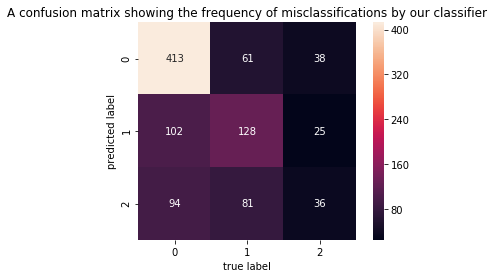

In [45]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)


Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  60.32719836400818
F1Score 0.30234864784216264
Precision 0.8763690596177725
Recall 0.6032719836400818
Sensitivity: 0.43%
Specificity: 100.00%


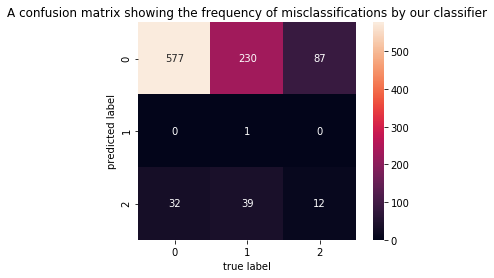

In [46]:
#Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)


## Logistic Regression

Feature Extraction using CV


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score ->  69.42740286298569
F1Score 0.4768262298322939
Precision 0.7699202850496837
Recall 0.6942740286298569
Sensitivity: 55.00%
Specificity: 88.67%


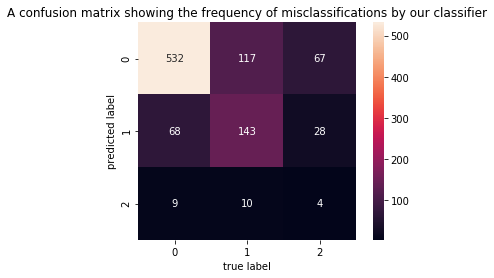

In [47]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Accuracy Score ->  70.24539877300614
F1Score 0.4483556031093076
Precision 0.8532091951173821
Recall 0.7024539877300614
Sensitivity: 41.48%
Specificity: 94.41%


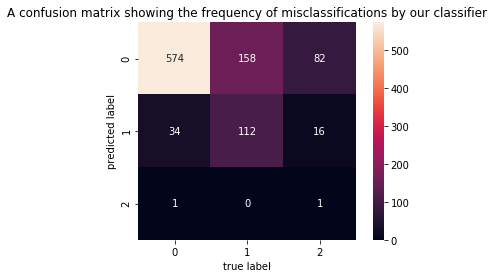

In [48]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)


Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  59.20245398773007
F1Score 0.49056522137938313
Precision 0.5602027406343039
Recall 0.5920245398773006
Sensitivity: 68.85%
Specificity: 81.66%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


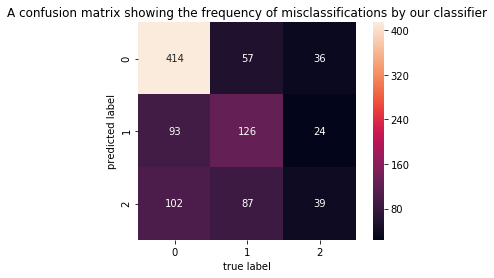

In [49]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)


Feature Extraction using CV
Accuracy Score ->  69.42740286298569
F1Score 0.4768262298322939
Precision 0.7699202850496837
Recall 0.6942740286298569
Sensitivity: 55.00%
Specificity: 88.67%


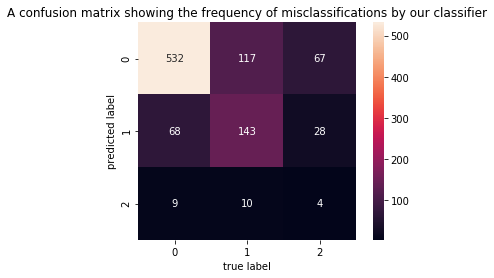

In [50]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)


Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  56.33946830265849
F1Score 0.4659394530538159
Precision 0.5247322554458863
Recall 0.5633946830265849
Sensitivity: 69.94%
Specificity: 80.08%


/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


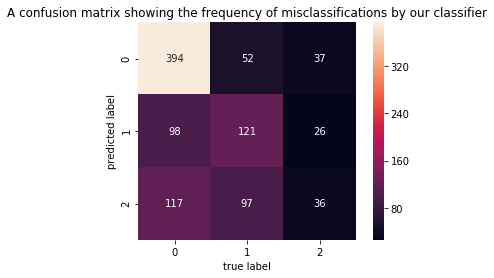

In [51]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)


Feature Extraction using CV
Oversampling the dataset
Accuracy Score ->  60.122699386503065
F1Score 0.4815453487016927
Precision 0.5854592733762044
Recall 0.6012269938650306
Sensitivity: 53.55%
Specificity: 87.90%


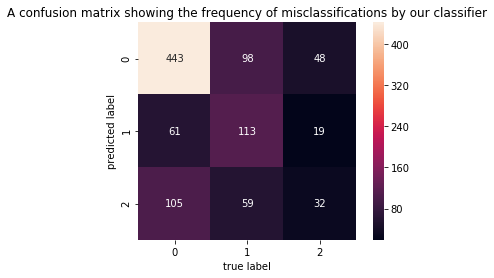

In [52]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = True)


Feature Extraction using TFIFD
Oversampling the dataset
Accuracy Score ->  63.80368098159509
F1Score 0.46219791734414634
Precision 0.7016135190135613
Recall 0.6380368098159509
Sensitivity: 36.13%
Specificity: 95.81%


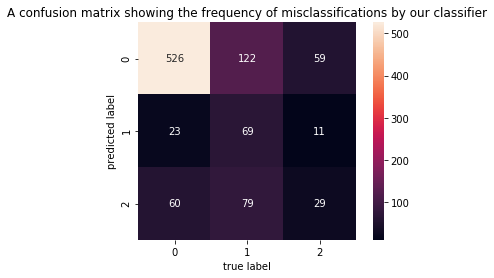

In [53]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = True)
